# Technical trials for note img processing

In [1]:
#!/usr/bin/env python3.7
# coding=utf-8
import os
import sys
# try:
#     # Run in Terminal
#     meta_pkg_path = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
# except:
#     # Run in ipykernel & interactive
#     meta_pkg_path = os.path.dirname(os.getcwd())
# if not (meta_pkg_path in sys.path):
#     sys.path.append(meta_pkg_path)
    
import cv2
from cv2 import cvtColor,adaptiveThreshold,bitwise_not,dilate,erode,connectedComponents,imread,imwrite
from cv2 import COLOR_RGB2GRAY,ADAPTIVE_THRESH_MEAN_C,THRESH_BINARY,COLOR_RGB2HSV,COLOR_HSV2RGB,COLOR_GRAY2RGB,COLOR_RGB2GRAY,IMWRITE_PNG_COMPRESSION
import numpy as np
from numpy import mean,ones,uint8,power
from matplotlib.pyplot import imshow,subplot
from note_color_threshold import BlackboardRecorder

In [15]:
name = 'e:/Temp/img/IMG_20210416_191131.jpg'
img = cv2.imread(name)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# 注意！plt.imshow是按照RGB来显示的，cv2.imshow是按照BGR显示的
# cv2.imshow("d",img)
# cv2.waitKey(0)

## IMG Calibration

Adaptive Threshold Research

FloatSlider(value=1.0, description='thresh_rad_rel:', max=5.0, readout_format='.1f', step=0.01)

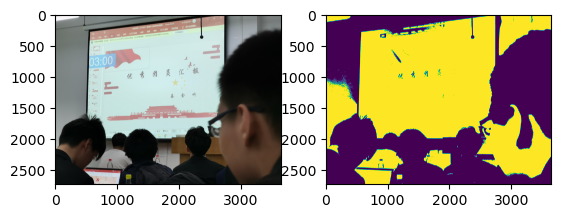

In [24]:
import ipywidgets.widgets as widgets
slider = widgets.FloatSlider(
    value=1,
    min=0,
    max=5.0,
    step=0.01,
    description='thresh_rad_rel:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
display(slider)

erode_rad_rel = 0.001
thresh_rad_rel = slider.value
thresh_bias = 0

erode_rad = int(erode_rad_rel*min(img.shape[:1]))+1
thresh_rad = int(thresh_rad_rel*min(img.shape[:1])/2)*2+1 # must be odd
grey = cvtColor(img,COLOR_RGB2GRAY)
thresh = adaptiveThreshold(grey,255,ADAPTIVE_THRESH_MEAN_C, THRESH_BINARY,thresh_rad,thresh_bias)
subplot(1,2,1)
imshow(img)
subplot(1,2,2)
imshow(thresh)

Draft

10 [    288     199    1991    2744 2311482]
[[ 324  216]
 [ 527 2944]
 [2101 2740]
 [2256  291]]
2376 2594


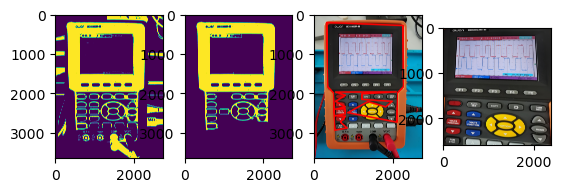

In [9]:
erode_rad_rel = 0.001
thresh_rad_rel = 0.6
thresh_bias = 30
erode_rad = int(erode_rad_rel*min(img.shape[:1]))+1
thresh_rad = int(thresh_rad_rel*min(img.shape[:1])/2)*2+1 # must be odd

grey = cvtColor(img,COLOR_RGB2GRAY)
thresh = adaptiveThreshold(grey,255,ADAPTIVE_THRESH_MEAN_C, THRESH_BINARY,thresh_rad,thresh_bias)
thresh = bitwise_not(thresh) # 反相(黑板需要)（或者同时查找）
erode_kernel = ones((erode_rad,erode_rad),uint8) #待改为圆形
thresh = erode(thresh,erode_kernel,iterations=1)


num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4, ltype=None)
subplot(1,4,1)
imshow(thresh)
# 有待改进
def find_blackboard(num_labels, labels, stats, centroids):
    img_area = labels.shape[0]*labels.shape[1]
    id_list = []
    area_coef = 0.3
    img_area_coef = 0.1
    for i in range(1,stats.__len__()):
        if (stats[i][4] > area_coef*stats[i][2]*stats[i][3] and
            stats[i][4] > img_area_coef*img_area): 
            id_list.append(i)
            print(i,stats[i])
    # 面积最大
    return id_list[stats[id_list, 4].argmax()]
id = find_blackboard(num_labels, labels, stats, centroids)
# id = 688
ROI = np.zeros(labels.shape,np.uint8)
ROI[labels == id] = 255
subplot(1,4,2)
imshow(ROI)

def get_polygon(labels, id):
    blank = np.zeros(labels.shape, dtype=np.uint8)
    blank[labels == id] = 255
    kernel = np.ones((5,5),np.uint8)
    blank = cv2.dilate(blank,kernel,iterations=1)
    contours, hierarchy = cv2.findContours(blank,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
    c0 =contours[0]
    # this para is important(decide the approximation, i.e. the polygon edge numbers)
    coef = 0.005 #0.05 default (Simpler when larger)
    epsilon = coef * cv2.arcLength(c0, True)
    approx = cv2.approxPolyDP(c0, epsilon, True)
    return approx

approx = get_polygon(labels,id)
draw_img = img.copy()
res = cv2.drawContours(draw_img, [approx], -1, (255, 0, 0), erode_rad*10)
subplot(1,4,3)
imshow(res) 

# print(approx[:,0])

def find_angular_point(points):
    ang_pt = points[:4].copy()
    for pt in points:
        if pt.sum() < ang_pt[0].sum(): ang_pt[0] = pt.copy()
        if pt.sum() > ang_pt[2].sum(): ang_pt[2] = pt.copy()
        if pt[0]-pt[1] < ang_pt[1][0]-ang_pt[1][1]: ang_pt[1] = pt.copy()
        if pt[0]-pt[1] > ang_pt[3][0]-ang_pt[3][1]: ang_pt[3] = pt.copy()
    return ang_pt

def wrap_size_est(ang_pt):
    img_h = int((np.linalg.norm(ang_pt[0]-ang_pt[1])+
             np.linalg.norm(ang_pt[2]-ang_pt[3]))/2)
    img_w = int((np.linalg.norm(ang_pt[1]-ang_pt[2])+
             np.linalg.norm(ang_pt[3]-ang_pt[1]))/2)
    return (img_w,img_h)

ang_pt = find_angular_point(approx[:,0])
print(ang_pt)
# target_img_shape = (img_w, img_h)
img_w, img_h = wrap_size_est(ang_pt)
print(img_w, img_h)
dst_points = np.array( [[0,0],[0,img_h],[img_w,img_h],[img_w,0]])

H, _ = cv2.findHomography(ang_pt, dst_points)
img_src_warp = cv2.warpPerspective(img, H, (img_w, img_h))
subplot(1,4,4)
imshow(img_src_warp)


Integrated

65 [   1365     773    1217    1009 1102279]
[[1370  848]
 [1363 1729]
 [2583 1783]
 [2583  771]]
1386 946


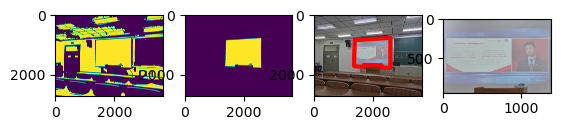

In [3]:
BR = BlackboardRecorder(img)
src_points, dst_points, (dst_img_w, dst_img_h) = BR.find_possible_ROIs(BR.thresh)
warp = BR.homography_projection(BR.img,src_points, dst_points, (dst_img_w, dst_img_h))

1 [      0       0    3648     837 1408889]
66 [      0    2121    3648     615 1185423]
[[   0    0]
 [   0  685]
 [3647  624]
 [3647  137]]
3667 586


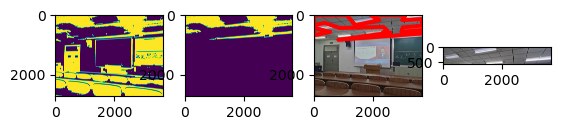

In [4]:
src_points, dst_points, (dst_img_w, dst_img_h) = BR.find_possible_ROIs(BR.thresh_ivt)
warp = BR.homography_projection(BR.img,src_points, dst_points, (dst_img_w, dst_img_h))

## Pre Processing

123.10774732000813


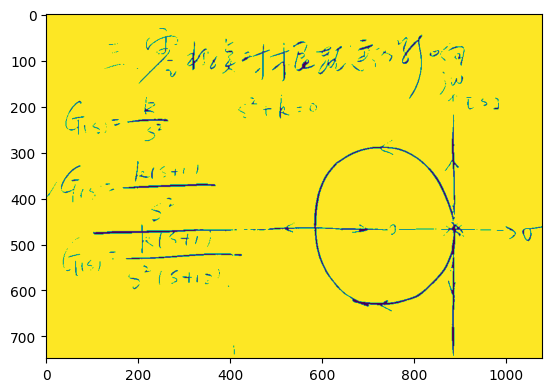

In [10]:
grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
print(np.mean(grey))
## 存在问题
if np.mean(grey)>127:
    grey = cv2.bitwise_not(grey)
thresh = cv2.adaptiveThreshold(grey,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,351,50)


# cv2.imwrite('BW.png',thresh, [cv2.IMWRITE_PNG_COMPRESSION, 9])
# plt.imshow(thresh)
kernel = np.ones((3,3),np.uint8)
dilate = cv2.dilate(thresh,kernel,iterations=1)

thresh = dilate
plt.imshow(thresh)

23


True

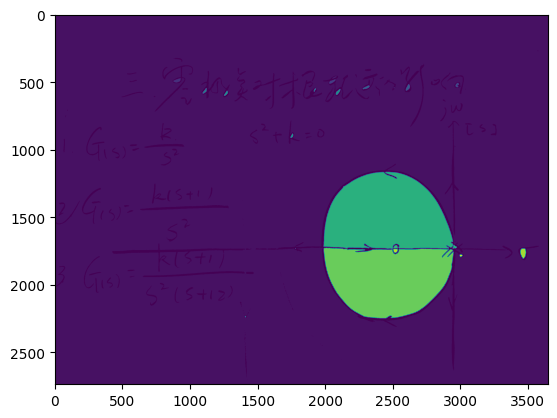

In [6]:
num_objects, labels = cv2.connectedComponents(thresh,connectivity=8)
print(num_objects)
plt.imshow(labels)
cv2.imwrite('labels.png',labels, [cv2.IMWRITE_PNG_COMPRESSION, 9])
###########
# imgcp = img.copy()
# imgcp[labels==1]=[255,0,0]
# plt.imshow(imgcp)

## Saturating

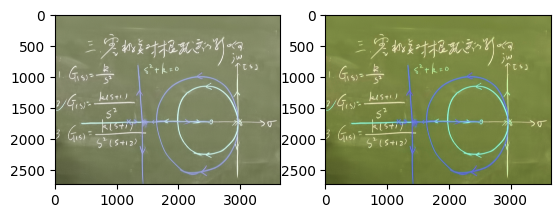

In [7]:
saturated = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
order = 0.5
saturated[:,:,1] = np.power(saturated[:,:,1]/255,order)*255
img_sat_remap = cv2.cvtColor(saturated, cv2.COLOR_HSV2RGB)
ax = plt.subplot(1,2,1)
plt.imshow(img)
ax = plt.subplot(1,2,2)
plt.imshow(img_sat_remap)

## Final Combination

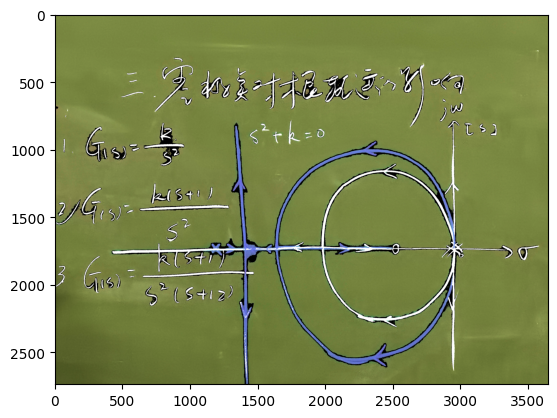

In [8]:
thresh_RGB = cv2.cvtColor(thresh,cv2.COLOR_GRAY2RGB)
thresh_RGB = cv2.bitwise_not(thresh_RGB)
filtered = img_sat_remap.copy()
# output = np.ones(img.shape,np.uint8)*255
# print(output)
# print(int(np.mean(img_sat_remap[labels==2][:,0])))
# for i in range(1,num_objects):
#     # output[labels == i] = [np.mean(img_sat_remap[labels==i][:,0]),
#     #                         np.mean(img_sat_remap[labels==i][:,1]),
#     #                         np.mean(img_sat_remap[labels==i][:,2])]
#     output[labels == i] = img_sat_remap[labels==i][0]

filtered[labels == 0] = [255,255,255]

filtered_HSV_Sat = cv2.cvtColor(filtered,cv2.COLOR_RGB2HSV)[:,:,1]

thresh_RGB[filtered_HSV_Sat>100] = filtered[filtered_HSV_Sat>100]
# thresh_RGB[labels == 0] = [255,255,255]


# print(output)
plt.imshow(thresh_RGB)
# print(labels)

In [122]:
cv2.imwrite('output.png',thresh_RGB, [cv2.IMWRITE_PNG_COMPRESSION, 9])
# print(np.mean(img[labels==8]))
# img[0,0]

True

## Test

123.10774732000813


True

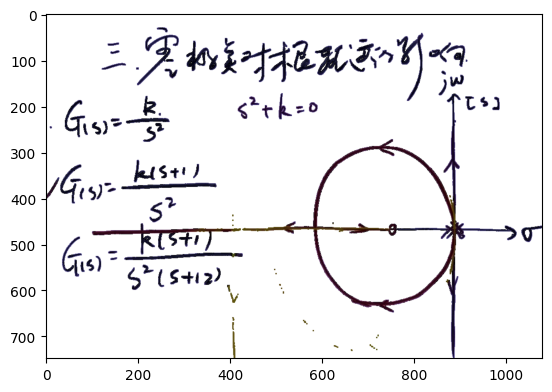

In [5]:
import note_color_threshold as nct
import numpy as np
from matplotlib import pyplot as plt
import cv2
name = 'test2.png'
img = cv2.imread(name)
# thresh_color = nct.note_color_threshold(img,0.6,0,127)
thresh_color = nct.note_color_threshold_for_white_bkg(img)

grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
print(np.mean(grey))
plt.imshow(thresh_color)
cv2.imwrite('thresh_color.png',thresh_color, [cv2.IMWRITE_PNG_COMPRESSION, 9])

## Click board test

In [5]:
import pyperclip
# pyperclip.copy('The text to be copied to the clipboard.')
pyperclip.paste()	# 'The text to be copied to the clipboard.'
# pyperclip.
print(pyperclip.paste())

In [9]:
from PIL import Image, ImageGrab
 
# 保存剪切板内图片
im = ImageGrab.grabclipboard()
 
if isinstance(im, Image.Image):
    print("Image: size : %s, mode: %s" % (im.size, im.mode))
    # im.save("E:\\Temp\\grab_clipboard.jpg")
elif im:
    for filename in im:
        print("filename:%s" % filename)
        im = Image.open(filename)
else:
    print("clipboard is empty")


clipboard is empty


In [12]:
# coding: utf-8

# pip install pillow, 用Image模块操作图片文件
from PIL import Image

# BytesIO是操作二进制数据的模块
from io import BytesIO

# pip install pywin32, win32clipboard是操作剪贴板的模块
import win32clipboard

# 图片路径，如果是当前路径，直接写文件名
# windows路径要注意是 \，例：'D:\\t.jpg'
# linux是 /，例: '~/t.jpg'
file_image = 'E:\\Temp\\img\\1.png'


def send_msg_to_clip(type_data, msg):
    """
    操作剪贴板分四步：
    1. 打开剪贴板：OpenClipboard()
    2. 清空剪贴板，新的数据才好写进去：EmptyClipboard()
    3. 往剪贴板写入数据：SetClipboardData()
    4. 关闭剪贴板：CloseClipboard()

    :param type_data: 数据的格式，
    unicode字符通常是传 win32con.CF_UNICODETEXT
    :param msg: 要写入剪贴板的数据
    """
    win32clipboard.OpenClipboard()
    win32clipboard.EmptyClipboard()
    win32clipboard.SetClipboardData(type_data, msg)
    win32clipboard.CloseClipboard()


def paste_img(file_img):
    """
    图片转换成二进制字符串，然后以位图的格式写入剪贴板

    主要思路是用Image模块打开图片，
    用BytesIO存储图片转换之后的二进制字符串

    :param file_img: 图片的路径
    """
    # 把图片写入image变量中
    # 用open函数处理后，图像对象的模式都是 RGB
    image = Image.open(file_img)

    # 声明output字节对象
    output = BytesIO()

    # 用BMP (Bitmap) 格式存储
    # 这里是位图，然后用output字节对象来存储
    image.save(output, 'BMP')

    # BMP图片有14字节的header，需要额外去除
    data = output.getvalue()[14:]

    # 关闭
    output.close()

    # DIB: 设备无关位图(device-independent bitmap)，名如其意
    # BMP的图片有时也会以.DIB和.RLE作扩展名
    # 设置好剪贴板的数据格式，再传入对应格式的数据，才能正确向剪贴板写入数据
    send_msg_to_clip(win32clipboard.CF_DIB, data)

paste_img(file_image)

ImportError: DLL load failed while importing win32clipboard: 找不到指定的程序。

# Note process
File Traversing

In [3]:
Folder_dir = 'E:\\Temp\\img'
# Folder_dir = 'D:\\Temp\\img'
# Folder_dir = '//media//raymon//182447EE2447CE06//Temp//img'
Thresh_dia = 501;di_rad = 0;bias = 40;mode = 0;auto_warp=False;Black_board = False;


{YRSEH]Q2S69~O801$9C([N


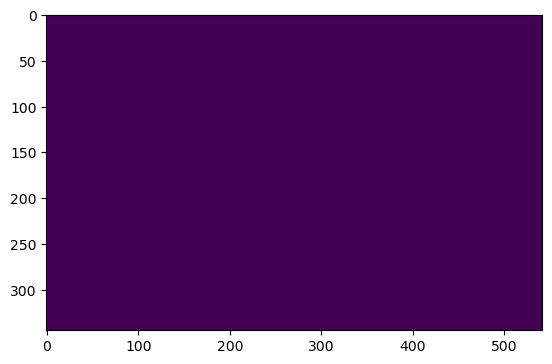

In [4]:
#!/usr/bin/env python3
# coding=utf-8
import cv2
import glob
import numpy as np
from matplotlib.pyplot import imshow
from pathlib import Path
import note_color_threshold as nct
# print(glob.glob(dir+'\\**\\*.jpg',recursive=True)) #全部搜索
#注意 Linux为// Win为\\
# file_dirs = glob.glob(Folder_dir+'\\*.jpg') +  glob.glob(Folder_dir+'\\*.png') #Win
file_dirs = glob.glob(Folder_dir+'//*.jpg') +  glob.glob(Folder_dir+'//*.png')  #Linux
# print(file_dirs,"\n========")
for file_dir in file_dirs:
    file_name = Path(file_dir).stem
    if not ('Thresh_' in file_name):
        print(file_name)
        # img = cv2.imread(file_dir)
        img = cv2.imdecode(np.fromfile(file_dir,dtype=np.uint8),-1) #可读取中文路径
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if auto_warp: 
            BR = nct.BlackboardRecorder(img)
            if Black_board: src_points, dst_points, (dst_img_w, dst_img_h) = BR.find_possible_ROIs(BR.thresh_ivt)
            else: src_points, dst_points, (dst_img_w, dst_img_h) = BR.find_possible_ROIs(BR.thresh)
            img = BR.homography_projection(BR.img,src_points, dst_points, (dst_img_w, dst_img_h))
        if Black_board:
            thresh = nct.note_color_threshold_for_black_bkg(img,dilate_rad=di_rad,Thresh_bias = bias,
                                                            Thresh_dia=Thresh_dia,mode=mode)
        else: 
            thresh = nct.note_color_threshold_for_white_bkg(img,dilate_rad=di_rad,Thresh_bias = bias,
                                                Thresh_dia=Thresh_dia,mode=mode)
        cv2.imwrite(Folder_dir+'\\Thresh_'+file_name+'.png', thresh, [cv2.IMWRITE_PNG_COMPRESSION, 9])
try:
    imshow(thresh)
    os.startfile(Folder_dir)
except:
    pass
